# Data Correlations

In [1]:
# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime

import locale # For currency formatting
locale.setlocale(locale.LC_ALL, '')

# Geographies
import shapely
from shapely.geometry import mapping, shape
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

# Common DGLIM utilities
import dglim
from dglim import City
from dglim import Region
from dglim import Colors
dglim.setProjectPath('../')
dglim.usePlotStyle()

%matplotlib inline

## Load Datasets

In [2]:
data_path = '../City_Data/BusinessesWithEndDateAndLifespan/'
master_df = dglim.loadData('Master Dataset')
blocks_df = dglim.loadData('Blocks Dataset')
tracts_df = dglim.loadData('Tracts Dataset')

gainesville_shape = dglim.getGainesvilleShape()
tract_shapes = dglim.getTractShapes(gainesville_shape)

*** Quantify success ***

In [3]:
active_df = master_df.copy()

success_label_values = {
    'Very Successful' : 1,
    'Somewhat Successful' : 1,
    'Somewhat Unsuccessful' : 0,
    'Very Unsuccessful' : 0
}
active_df['Successful'] = active_df['Successfulness'].apply(lambda x: success_label_values[x] if (type(x) == str) else np.nan)

len(active_df)

7044

*** For location-independent analysis, eliminate duplicate business entries for unique locations ***

In [4]:
merged_locations_df = active_df.drop_duplicates(subset=['GRU ID', 'Address'])
len(merged_locations_df)

5528

## Correlation Between Lifespan and Success

*** Calculate life spans in number of days ***

In [5]:
current_time = datetime(2017, 11, 1) # Date the ActiveBusinesses dataset was last modified

active_df['Life Span'] = active_df['Start Date'].apply(lambda x: math.floor((current_time - x).days//365.25))

*** Plot life span vs. success ***

--- Success Distribution ---
Somewhat Successful      253
Very Successful          231
Somewhat Unsuccessful     27
Very Unsuccessful          8

--- At least 16 years old ---
Very Successful          90
Somewhat Successful      64
Somewhat Unsuccessful     1

--- Analysis ---
Total businesses represented: 519
Total at least 16 years old: 155
Correlation between success and age: 0.703897820625


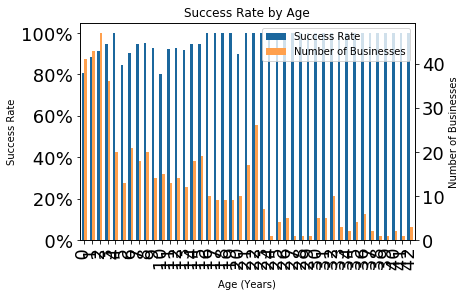

In [6]:
active_with_success_df = active_df[['Life Span', 'Successful', 'Successfulness']].dropna()

temp_df = active_with_success_df \
    .groupby('Life Span', as_index=False).mean() \
    .sort_values(by='Life Span')

temp_df['Successful'] = temp_df['Successful']
temp_df['Total Businesses'] = active_with_success_df['Life Span'].value_counts()

# Plot
ax = temp_df[['Life Span', 'Successful', 'Total Businesses']].plot(
        kind='bar', xlim=(0, 21), width=.67, legend=True,
        x='Life Span', secondary_y=['Total Businesses'])

ax.set_title('Success Rate by Age')
ax.set_xlabel('Age (Years)')
ax.set_ylabel('Success Rate')
ax.right_ax.set_ylabel('Number of Businesses')

# Change x axis to integers
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}'.format(x) for x in vals], rotation=90);

# Hide old legend
ax.get_legend().set_visible(False)

# Make new legend
ax1_handles, ax1_labels = ax.get_legend_handles_labels()
ax2_handles, ax2_labels = ax.right_ax.get_legend_handles_labels()
plt.legend(ax1_handles + ax2_handles, ['Success Rate', 'Number of Businesses'], loc=1)

# Change y axis to percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);

# Print some numbers
print "--- Success Distribution ---"
print active_df['Successfulness'].value_counts().to_string()
print
print "--- At least 16 years old ---"
print active_df[active_df['Life Span'] >= 16]['Successfulness'].value_counts().to_string()
print

print "--- Analysis ---"
print "Total businesses represented:", len(active_with_success_df)
print "Total at least 16 years old:", len(active_with_success_df[active_with_success_df['Life Span'] >= 16]['Successfulness'])
print "Correlation between success and age:", temp_df['Successful'].corr(temp_df['Life Span'])
# print "Correlation between success and age:", active_with_success_df['Successful'].corr(active_with_success_df['Life Span'])

In [7]:
a = active_df['Successfulness'].value_counts()
print a.to_string()

Somewhat Successful      253
Very Successful          231
Somewhat Unsuccessful     27
Very Unsuccessful          8


## Correlation Between Electricity Consumption and Business Success

In [8]:
temp_df = active_df[['Percent Change in KWH', 'Successful']].copy()
temp_df['KWH Trend'] = temp_df['Percent Change in KWH'].apply(lambda x: 1 if x >= 0 else 0)

print "0 means negative or no rise in the electricity bills"
print "1 means there is steady rise in the electricity consumption"
print temp_df['KWH Trend'].value_counts()

0 means negative or no rise in the electricity bills
1 means there is steady rise in the electricity consumption
0    6690
1     354
Name: KWH Trend, dtype: int64


In [9]:
print "Of the surveyed businesses,"
print temp_df.dropna()['KWH Trend'].value_counts()

Of the surveyed businesses,
0    162
1     43
Name: KWH Trend, dtype: int64


In [10]:
print "Correlation between trend in electricity consumption and success:"
print temp_df['Successful'].corr(temp_df['KWH Trend'])

Correlation between trend in electricity consumption and success:
0.0529520170348


## Correlation between Nearby Crimes and Business Success

Negative correlations are fine - nearby crime should have a negative impact on success.

** Note: ** Correlations of NaN appear when all of the businesses are successful (when success values are 1, there is no variance and the correlation cannot be computed)

In [11]:
crimes_df = active_df[[
    'DGLIM ID',
    'Business Type',
    'NAICS Type',
    'Successful',
    'Nearby Crimes in 2016'
]].dropna(subset=['Successful'])

In [12]:
def getSpecificCrimeCorrelation(input_df, column, value, threshold):
    slice_df = input_df[input_df[column] == value]
    values = pd.Series(name=value)
    values['Correlation'] = slice_df['Successful'].corr(slice_df['Nearby Crimes in 2016'] >= threshold)
    values['Number of Businesses'] = len(slice_df)
    values[column] = value

    return values

*** All businesses ***

In [13]:
best_correlation = 0
best_threshold = 0

for threshold in [x * 10 for x in range(1, 70)]:
    correlation = crimes_df['Successful'].corr(crimes_df['Nearby Crimes in 2016'] >= threshold)

    if abs(correlation) > abs(best_correlation):
        best_correlation = correlation
        best_threshold = threshold

print "Correlation between trend in nearby crime rate and success"
print "Best correlation is", best_correlation, "at a threshold of", best_threshold, "crimes"

Correlation between trend in nearby crime rate and success
Best correlation is -0.101368639196 at a threshold of 100 crimes


*** By City type ***

In [14]:
city_types = pd.Series(crimes_df['Business Type'].unique())
city_type_correlations_df = city_types.apply(
    lambda city_type:
        getSpecificCrimeCorrelation(crimes_df, 'Business Type', city_type, best_threshold)
)

city_type_correlations_df.set_index('Business Type').sort_values(by='Correlation')

/home/asiglani/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


,Correlation,Number of Businesses
Business Type,,
PROFESSIONAL NOT OTHERWISE LICENSED,-1.000000,2.0
LABORATORY,-1.000000,2.0
"CAR CLEANING, WAXING, DETAILING",-1.000000,3.0
GRAPHIC ARTS & DRAFTING,-0.632456,6.0
MANUFACTURING-WOOD PRODUCTS,-0.500000,3.0
SCHOOL NOT OTHERWISE LISTED,-0.487950,8.0
CONSULTANT,-0.368514,20.0
NURSERY SCHOOL AND/OR CHILD DAYCARE,-0.258199,7.0
PROFESSIONAL-ACUPUNCTURE,-0.239046,11.0


*** By NAICS type ***

In [15]:
naics_types = pd.Series(crimes_df['NAICS Type'].unique())
naics_type_correlations_df = naics_types.apply(
    lambda naics_type:
        getSpecificCrimeCorrelation(crimes_df, 'NAICS Type', naics_type, best_threshold)
)

naics_type_correlations_df.set_index('NAICS Type').sort_values(by='Correlation')

,Correlation,Number of Businesses
NAICS Type,,
Transportation and Warehousing,-0.447214,6.0
Wholesale trade,-0.333333,10.0
Educational Services,-0.327327,15.0
"Professional, Scientific, and Technical Services",-0.229297,124.0
Real Estate Rental and Leasing,-0.191204,32.0
Other Services,-0.184637,35.0
Accommodation and Food Services,-0.071743,41.0
Retail Trade,-0.021116,69.0
"Admin., Support, Waste Mgmt., Remediation",-0.020728,33.0


## Correlation between Permits/Violations and Business Success

In [16]:
permits_corr = active_df['Number of Permits'].corr(active_df['Successful'])
zoning_corr = active_df['Number of Zoning Violations'].corr(active_df['Successful'])
code_corr = active_df['Number of Building Code Violations'].corr(active_df['Successful'])

print "Correlation between number of permits and success:", permits_corr
print "Correlation between number of zoning violations and success:", zoning_corr
print "Correlation between number of building code violations and success:", code_corr

Correlation between number of permits and success: 0.0416301972167
Correlation between number of zoning violations and success: 0.0453834377822
Correlation between number of building code violations and success: 0.0299848794393


## Correlation between Profit and Business Success ##

In [17]:
profit_2016 = (active_df['Revenue in 2016'] - active_df['Expenses in 2016']).astype('float64')
profit_2017 = (active_df['Revenue in 2017'] - active_df['Expenses in 2017']).astype('float64')

print "Correlation between profit in 2016 and success:", (profit_2016 > 0).corr(active_df['Successful'])
print "Correlation between profit in 2017 and success:", (profit_2017 > 0).corr(active_df['Successful'])

Correlation between profit in 2016 and success: 0.0681649292671
Correlation between profit in 2017 and success: 0.0817057169103


## Correlation between Bus Stop Distance and Business Success ##

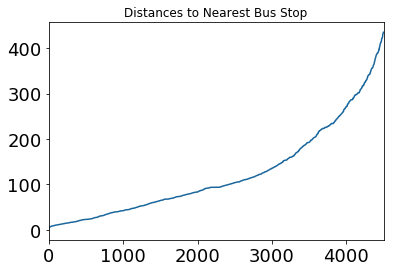

In [18]:
stop_success_df = merged_locations_df[['Business Type', 'Distance to Bus Stop', 'Successful']]

stop_success_df = stop_success_df.sort_values(ascending=True, by='Distance to Bus Stop')
graph = stop_success_df['Distance to Bus Stop'][:4500].plot(kind='line', use_index=False, title='Distances to Nearest Bus Stop')

*** Bin bus stop distances ***

In [19]:
# Filter out businesses that did not answer the survey
stop_success_df = stop_success_df.dropna()

# Let's make some bins
num_bins = 10
average_bin_size = float(len(stop_success_df))/float(num_bins)

bin_ranges = list()

# Use sorted distances
distances = stop_success_df['Distance to Bus Stop'].tolist()

print "Bin ranges:"
last = -1
for i in range(0, num_bins):
    first = last + 1
    last = min(len(distances) - 1, int(float(i + 1)*average_bin_size))

    bin_ranges.append((distances[first], distances[last]))

    if (i < 10):
        print i, ":", bin_ranges[i]
    if (i == 10):
        print "... (", (num_bins - i), " more)"

Bin ranges:
0 : (6.301801769414178, 23.39250887729191)
1 : (23.39250887729191, 44.33684712611125)
2 : (45.04195015584829, 64.63839605573796)
3 : (64.83602415053204, 82.7016142088125)
4 : (82.99257012318466, 105.65708626645423)
5 : (105.65708626645423, 147.17015552325182)
6 : (152.50015597405044, 221.18957315951658)
7 : (221.37969127493778, 286.4370851435853)
8 : (289.82139976681333, 411.01394502122344)
9 : (413.84302876357583, 1160.7202624964457)


In [20]:
# Filter by type
#stop_success_df = stop_success_df[stop_success_df['Business Type'] == 'RESTAURANT']

stop_success_df[['Successful', 'Distance to Bus Stop']][::100]

,Successful,Distance to Bus Stop
DGLIM ID,,
3279,1.0,6.301802
3514,0.0,42.565631
2045,1.0,80.424251
748,1.0,142.935428
5275,1.0,275.501012
1861,1.0,768.538201


In [21]:
# Count success rate in each bin

# Initialize bin counts
bin_counts = []
for i in range(0, num_bins):
    bin_counts.append([0, 0]) # (total, successful)

# Count successful businesses in each bin range
for i, entry in stop_success_df.iterrows():
    successful = entry['Successful']
    distance = entry['Distance to Bus Stop']
    
    # Find the correct bin
    for i in range(0, num_bins):
        first = bin_ranges[i][0]
        last = bin_ranges[i][1]
        
        if (distance <= last):
            bin_counts[i][0] += 1
            bin_counts[i][1] += successful
            break;

In [22]:
distance_bins_df = pd.DataFrame(data=bin_counts, columns=['Total Businesses', 'Total Successful'])
distance_bins_df['Success Rate'] = np.round(100*(distance_bins_df['Total Successful']/distance_bins_df['Total Businesses']).apply(lambda x : 0 if np.isnan(x) else x))

distance_bins_df['Min Distance'] = [x[0] for x in bin_ranges]
distance_bins_df['Min Distance'] = distance_bins_df['Min Distance'].astype('int')

distance_bins_df['Max Distance'] = [x[1] for x in bin_ranges]
distance_bins_df['Max Distance'] = distance_bins_df['Max Distance'].astype('int')

distance_bins_df['Average Distance'] = (distance_bins_df['Min Distance'] + distance_bins_df['Max Distance'])/2
distance_bins_df['Average Distance'] = distance_bins_df['Average Distance'].astype('int')

distance_bins_df['Distance Range'] = distance_bins_df['Min Distance'].apply(lambda x: str(x)) + " - " + distance_bins_df['Max Distance'].apply(lambda x: str(x)) + ' m'
distance_bins_df.set_value(col='Distance Range', index=9, value=str(int(bin_ranges[num_bins-2][1])) + '+ m')

distance_bins_df

,Total Businesses,Total Successful,Success Rate,Min Distance,Max Distance,Average Distance,Distance Range
0,53,52.0,98.0,6,23,14,6 - 23 m
1,51,48.0,94.0,23,44,33,23 - 44 m
2,51,45.0,88.0,45,64,54,45 - 64 m
3,52,46.0,88.0,64,82,73,64 - 82 m
4,53,51.0,96.0,82,105,93,82 - 105 m
5,50,48.0,96.0,105,147,126,105 - 147 m
6,51,46.0,90.0,152,221,186,152 - 221 m
7,52,49.0,94.0,221,286,253,221 - 286 m
8,51,46.0,90.0,289,411,350,289 - 411 m
9,51,50.0,98.0,413,1160,786,411+ m


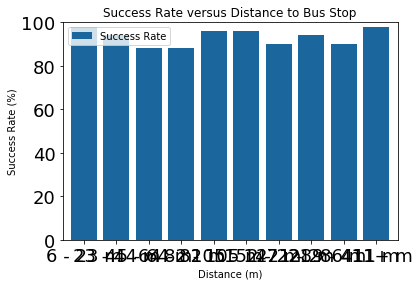

In [23]:
# ,  xlim=[0, bin_ranges[num_bins-1][0]]
graph = distance_bins_df.plot(y='Success Rate', x='Distance Range', kind='bar', width=.8, ylim=[0, 100], rot=0)

graph.set_title('Success Rate versus Distance to Bus Stop')
graph.set_xlabel('Distance (m)')
graph.set_ylabel('Success Rate (%)')

In [24]:
corr = distance_bins_df['Success Rate'].corr(distance_bins_df['Average Distance'])
print "Correlation:", corr

Correlation: 0.282138339649


## Correlation between Income and Business Success

*** By Census block group ***

In [25]:
success_labels = ['Somewhat Successful', 'Somewhat Unsuccessful', 'Very Successful', 'Very Unsuccessful']
success_by_block_df = blocks_df[[x for x in blocks_df.columns if x not in success_labels]].copy()
success_by_block_df['Total Responses'] = blocks_df.filter(items=success_labels).sum(axis='columns')
success_by_block_df['Successful'] = blocks_df['Very Successful'] + blocks_df['Somewhat Successful']
success_by_block_df['Success Rate'] = 100*(success_by_block_df['Successful']/success_by_block_df['Total Responses'])

print "Number of block groups:", len (success_by_block_df)

success_by_block_df.dropna(inplace=True)
success_by_block_df.head()

Number of block groups: 155


,Tract,Block,Population Working,Average Income,Total Businesses,Total Responses,Successful,Success Rate
Tract-Block,,,,,,,,
1000-2,1000,2,428,69147,59.0,8.0,7.0,87.500000
1000-3,1000,3,773,28835,79.0,6.0,5.0,83.333333
1000-4,1000,4,582,66056,18.0,3.0,3.0,100.000000
1000-5,1000,5,278,133075,7.0,1.0,1.0,100.000000
1100-1,1100,1,592,96300,38.0,4.0,4.0,100.000000


*** By Census tract ***

In [26]:
success_labels = ['Somewhat Successful', 'Somewhat Unsuccessful', 'Very Successful', 'Very Unsuccessful']
success_by_tract_df = tracts_df[[x for x in tracts_df.columns if x not in success_labels]].copy()
success_by_tract_df['Total Responses'] = tracts_df.filter(items=success_labels).sum(axis='columns')
success_by_tract_df['Successful'] = tracts_df['Very Successful'] + tracts_df['Somewhat Successful']

use_graded_scale = False

# Use graded scale
if use_graded_scale:
    success_by_tract_df['Success Rate'] = 100*((tracts_df['Very Successful'] + tracts_df['Somewhat Successful']*.67 + tracts_df['Somewhat Unsuccessful']*.33)/success_by_tract_df['Total Responses'])

# Use binary scale
else:
    success_by_tract_df['Success Rate'] = 100*((tracts_df['Very Successful'] + tracts_df['Somewhat Successful'])/success_by_tract_df['Total Responses'])

print "Number of tracts:", len (success_by_tract_df)

success_by_tract_df.dropna(inplace=True)
success_by_tract_df

Number of tracts: 44


,Tract,Population,Population Female,Population Over 18,Population Female Over 18,GEOID,Population Working,Average Income,Total Businesses,Total Responses,Successful,Success Rate
Tract,,,,,,,,,,,,
1000,1000,6075,2766,5490,2452,12001001000,2397.0,407098.0,171,18.0,16.0,88.888889
1100,1100,7220,3893,5400,2895,12001001100,2974.0,375410.0,393,32.0,30.0,93.750000
1201,1201,3226,1795,2486,1384,12001001201,1264.0,90937.0,109,9.0,9.0,100.000000
1202,1202,6531,3389,5064,2575,12001001202,2972.0,350261.0,116,11.0,10.0,90.909091
1203,1203,3689,1964,2801,1598,12001001203,1531.0,118136.0,75,7.0,6.0,85.714286
1514,1514,1427,772,1087,540,12001001514,691.0,76446.0,15,7.0,7.0,100.000000
1515,1515,4872,2578,4175,2216,12001001515,2169.0,95119.0,69,6.0,5.0,83.333333
1516,1516,1804,962,1465,794,12001001516,944.0,72423.0,5,1.0,1.0,100.000000
1517,1517,5279,2680,4429,2373,12001001517,2007.0,65339.0,47,8.0,8.0,100.000000


### Plotting Parameters

In [27]:
# Make a vertical plot
plot_verbose = False

# Make a sideways plot
plot_compact = True

# Ignore blocks with insufficient data
min_total_businesses = 5

# Which datasets should we plot?
# - success_by_block_df
# - tracts_df
df_list = list([
#     success_by_block_df,
    success_by_tract_df,
])
        
print "Analyzing", len(df_list), "datasets"

print "Number of blocks: ", len(success_by_block_df[success_by_block_df['Total Businesses'] > min_total_businesses])
print "Number of tracts: ", len(tracts_df[tracts_df['Total Businesses'] > min_total_businesses])

Analyzing 1 datasets
Number of blocks:  75
Number of tracts:  34


In [28]:
def makePlots(datasets, columns, xaxis=None, sort_by=None, min_total_businesses=min_total_businesses, normalize=True):
    for df in datasets:
        temp_df = pd.DataFrame(df[df['Total Businesses'] > min_total_businesses]).copy()

        if normalize:
            for column in columns:
                temp_df[column] = 100*temp_df[column]/max(temp_df[column])

        # Interpret arguments
        xaxis_name = temp_df.index.name if xaxis == None else xaxis
        sort_by = xaxis_name if sort_by == None else sort_by
        sort_axis = 'index' if sort_by == None else 'columns'

        # Format title
        # * Must be done before changing index
        title = columns[0]
        if (len(columns) > 1):
            title += ' versus ' + columns[1]
#         if (not temp_df.index.name == xaxis_name):
        title += ' per ' + temp_df.index.name

        # Sort
        if (not sort_by == temp_df.index.name):
            temp_df.set_index(keys=sort_by, drop=False, inplace=True)
        temp_df.sort_index(inplace=True)

        if (sort_axis == 'index'):
            temp_df.sort_index(inplace=True)
        else:
            temp_df.sort_values(by=sort_by, inplace=True)

        # Format data nicely
#         if (xaxis_name == 'Average Income'):
#             temp_df['Avg. Income'] = temp_df['Average Income']
#             temp_df['Average Income'] = temp_df['Average Income'].apply(lambda x: str(locale.currency(x, grouping=True)).split('.')[0])
#             columns = ['Avg. Income' if x == 'Average Income' else x for x in columns]
#             scale_name = 'Avg. Income'

        # Scale x-axis column
        if xaxis_name in columns:
            scale = 50
            max_val = temp_df[xaxis_name].max();
            temp_df[xaxis_name] = temp_df[xaxis_name].apply(lambda x: scale*x/max_val)

        # Format x-axis
        rot = 0 if (xaxis_name == 'Tract') else 90
        
        # Format bars
        width = 1 - .5/len(columns)
        print xaxis_name
        #temp_df.set_index(keys=xaxis_name, inplace=True, drop=False)

        # Plot
        if (plot_verbose):
            graph = temp_df.plot(y=columns, kind='barh', ylim=[0, 100], width=width, rot=rot)

            graph.set_title(title)
            graph.set_xlabel('Success Rate (%)')
            graph.set_ylabel(xaxis_name)

        # Plot compact
        if (plot_compact):
            graph = temp_df.plot(x=xaxis_name, y=columns, kind='bar', ylim=[0, 100], width=width, rot=rot)

            graph.set_title(title)
            graph.set_xlabel(xaxis_name)
            graph.set_ylabel('Success Rate (%)')

### Sort by Success Rate

Tract


-0.32282440303229348

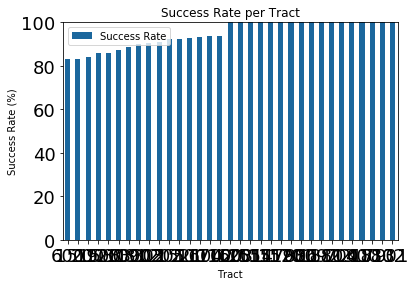

In [29]:
makePlots(datasets=df_list, columns=['Success Rate'], sort_by=["Success Rate"], normalize=False)
success_by_tract_df['Success Rate'].corr(success_by_tract_df['Total Businesses'])

### Sort by Total Population

Tract


-0.41866941262166618

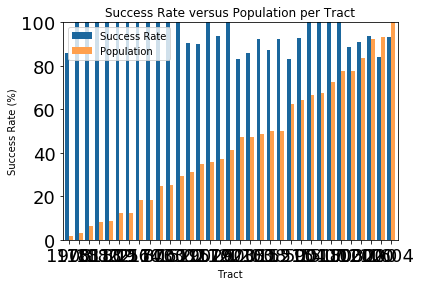

In [30]:
makePlots(datasets=df_list, columns=['Success Rate', 'Population'], sort_by='Population')
success_by_tract_df['Success Rate'].corr(success_by_tract_df['Population'])

### Sort by Average Income

Tract


-0.23040046703019834

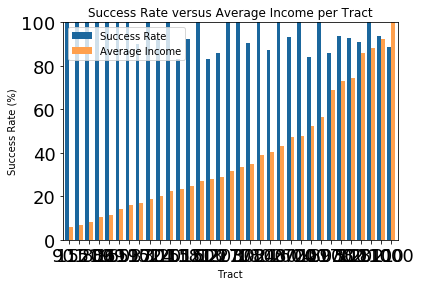

In [31]:
makePlots(datasets=df_list, columns=['Success Rate', 'Average Income'], sort_by='Average Income')
success_by_tract_df['Success Rate'].corr(success_by_tract_df['Average Income'])

### Sort by Number of Businesses

Tract


-0.32282440303229348

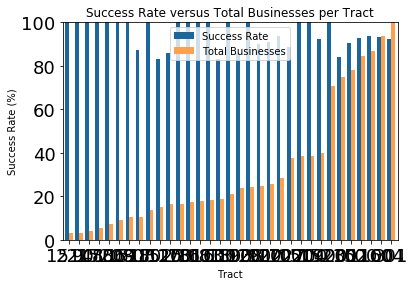

In [32]:
makePlots(datasets=df_list, columns=['Success Rate', 'Total Businesses'], sort_by='Total Businesses')
success_by_tract_df['Success Rate'].corr(success_by_tract_df['Total Businesses'])

## Metrics by Region

### Using Tracts

*** Divide Gainesville into four regions ***

In [33]:
line_ns = LineString([(City.longitude, City.latitude - 2), (City.longitude, City.latitude + 2)])
line_ew = LineString([(City.longitude - 2, City.latitude), (City.longitude + 2, City.latitude)])

center = (City.longitude, City.latitude)
west = (City.longitude - 2, City.latitude)
north = (City.longitude, City.latitude + 2)
east = (City.longitude + 2, City.latitude)
south = (City.longitude, City.latitude - 2)

mask = {}
mask[Region.NW] = shapely.geometry.Polygon([(west[0], north[1]), north, center, west])
mask[Region.NE] = shapely.geometry.Polygon([(east[0], north[1]), east, center, north])
mask[Region.SE] = shapely.geometry.Polygon([(east[0], south[1]), south, center, east])
mask[Region.SW] = shapely.geometry.Polygon([(west[0], south[1]), west, center, south])

regions = {}
for direction in Region:
    regions[direction] = gainesville_shape.intersection(mask[direction])

*** Draw regions with business locations ***

/home/asiglani/anaconda2/lib/python2.7/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


East-west boundaries: (-82.4223898406203, -82.2223916783364)
North-south boundaries: (29.5928305172926, 29.7783563820721)


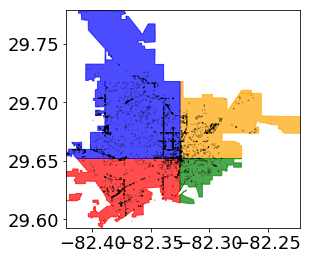

In [34]:
# Draw regions
plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

colors = {
    Region.NW: 'blue',
    Region.NE: 'orange',
    Region.SE: 'green',
    Region.SW: 'red'
}
bounds = [dglim.City.longitude, dglim.City.latitude, dglim.City.longitude, dglim.City.latitude]
for region_id in regions:
    r = regions[region_id]
    
    polygon = r
    patch = PolygonPatch(polygon, facecolor=[0,0,0.5], edgecolor=[0,0,0], alpha=0.7, zorder=2, color=colors[region_id])
    ax.add_patch(patch)

    bounds[0] = min(bounds[0], polygon.bounds[0])
    bounds[1] = min(bounds[1], polygon.bounds[1])
    bounds[2] = max(bounds[2], polygon.bounds[2])
    bounds[3] = max(bounds[3], polygon.bounds[3])

temp_df = merged_locations_df[['Latitude', 'Longitude']].dropna()
for i, location in temp_df.iterrows():
    point = shapely.geometry.Point(float(location['Longitude']), float(location['Latitude']))
    polygon = point.buffer(.0001,)
    patch = PolygonPatch(polygon, facecolor=[0,0,0.5], edgecolor=[0,0,0], alpha=0.7, zorder=2, color='black')
    ax.add_patch(patch)

print "East-west boundaries:", plt.xlim(bounds[0], bounds[2])
print "North-south boundaries:", plt.ylim(bounds[1], bounds[3])

*** Businesses by region ***

In [35]:
print "Number of unique business locations:", len(merged_locations_df)

Number of unique business locations: 5528


In [36]:
regions_df = pd.DataFrame(index=Region, columns=['Population', 'Businesses'])
regions_df['Businesses'] = merged_locations_df[['Latitude','Longitude']].dropna().apply(dglim.getRowRegion, axis=1).value_counts()

regions_df

,Population,Businesses
Region.NE,NaN,735
Region.SE,NaN,283
Region.SW,NaN,986
Region.NW,NaN,2968


*** Population by region ***

In [37]:
regions_df['Population'] = 0
for i, tract in tracts_df.iterrows():
    if i not in tract_shapes:
        continue

    # Interset with each region
    shp = tract_shapes[i]['Shape']
    total_area = shp.area
    for region_id in regions:
        area = shp.intersection(regions[region_id]).area
        regions_df.loc[region_id]['Population'] += tract['Population'] * (area/total_area)

total_population = regions_df['Population'].sum()
regions_df

,Population,Businesses
Region.NE,15889,735
Region.SE,4175,283
Region.SW,53616,986
Region.NW,51075,2968


*** Visualize distributions ***

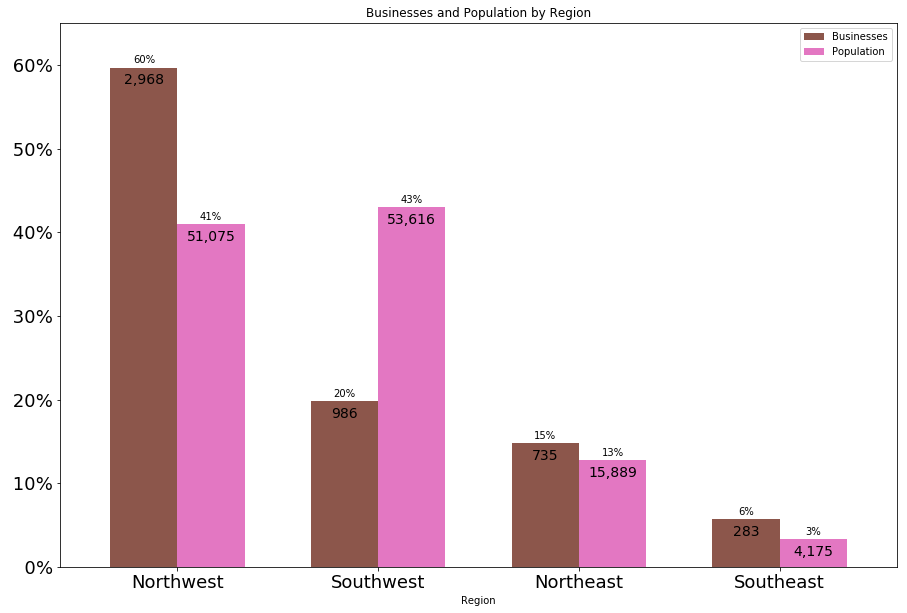

In [38]:
temp_df = regions_df[['Businesses', 'Population']].copy()

total_population = regions_df['Population'].sum()
temp_df['Normalized Population'] = regions_df['Population']/total_population

total_businesses = regions_df['Businesses'].sum()
temp_df['Normalized Businesses'] = regions_df['Businesses']/total_businesses
temp_df.sort_values(by='Businesses', ascending=False, inplace=True)

fig = plt.figure()

ax = temp_df[['Normalized Businesses', 'Normalized Population']].plot(
    figsize=(15, 10), ylim=(0, .65), kind='bar', width=0.67, color=[Colors.brown, Colors.pink])
labels = ax.get_xticklabels()
labelsText = [l.get_text() for l in labels]

labelsText = map(lambda x: {
    'Region.NE': 'Northeast',
    'Region.SE': 'Southeast',
    'Region.SW': 'Southwest',
    'Region.NW': 'Northwest'
}[x], labelsText)

# labelsText[0] = 'Northwest'
# labelsText[1] = 'Southwest'
# labelsText[2] = 'Northeast'
# labelsText[3] = 'Southeast'

ax.set_xlabel('Region')
ax.set_title('Businesses and Population by Region')
ax.legend(['Businesses', 'Population'])

# Change y axis to percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

# Write bar values
patches_len = len(ax.patches)
half = patches_len/2
ax.set_xticklabels(labelsText, rotation = 0)
for i, p in enumerate(ax.patches):
    pos = (
        p.get_x()+ p.get_width()/2,
        p.get_height() +.005
    )
    norm = p.get_height()
    count = temp_df['Businesses'][i] if i < half else temp_df['Population'][i - half]

    # Percentage
    ax.annotate(str(int(round(100 * p.get_height()))) + '%', pos, ha='center')

    # Total
    pos = (pos[0], pos[1] - .025)
    ax.annotate("{:,}".format(count), pos, ha='center', size=14)

In [39]:
temp_df = merged_locations_df[['Name', 'Latitude', 'Longitude']].dropna().copy()
temp_df['Region'] = merged_locations_df[['Latitude','Longitude']].apply(dglim.getRowRegion, axis=1)
temp_df['Region'].value_counts()

Region.NW    2968
Region.SW     986
Region.NE     735
Region.SE     283
Name: Region, dtype: int64

## People per Business

In [40]:
temp_df = tracts_df[['Total Businesses', 'Population']].copy()
temp_df['People per Business'] = temp_df['Population'] / temp_df['Total Businesses']

successful = tracts_df['Somewhat Successful'] + tracts_df['Very Successful']
unsuccessful = tracts_df['Somewhat Unsuccessful'] + tracts_df['Very Unsuccessful']
temp_df['Success Rate'] = successful/(successful + unsuccessful).fillna(1)

temp_df = temp_df[temp_df['Total Businesses'] > 0].dropna()
print "People-per-Business correlated with Success Rate:", temp_df['Success Rate'].corr(temp_df['People per Business'])
temp_df[temp_df['Total Businesses'] > 10]

People-per-Business correlated with Success Rate: 0.20347435948


,Total Businesses,Population,People per Business,Success Rate
Tract,,,,
1000,171,6075,35.526316,0.888889
1100,393,7220,18.371501,0.937500
1201,109,3226,29.596330,1.000000
1202,116,6531,56.301724,0.909091
1203,75,3689,49.186667,0.857143
1514,15,1427,95.133333,1.000000
1515,69,4872,70.608696,0.833333
1517,47,5279,112.319149,1.000000
1519,175,2781,15.891429,1.000000


In [42]:
master_df['NAICS Type'].value_counts()

Retail Trade                                        1159
Professional, Scientific, and Technical Services    1027
Other Services                                      1002
Finance & Insurance                                  608
Health Care and Social Assistance                    587
Construction                                         568
Real Estate Rental and Leasing                       538
Accommodation and Food Services                      524
Admin., Support, Waste Mgmt., Remediation            433
Wholesale trade                                      169
Manufacturing                                        147
Transportation and Warehousing                        86
Educational Services                                  85
Arts, Entertainment, and Recreation                   74
Information                                           23
Wholesale trade                                        8
Agriculture, Forestry, Fishing and Hunting             2
Manufacturing/Wholesale trade  

In [45]:
master_df[master_df['NAICS Type'] == 'Retail Trade']['Business Type'].value_counts()

RETAIL MERCHANT                        845
CATALOGUE OR MAIL ORDER SERVICE         84
COIN-OP VENDING MACHINES                54
GAS OR FUELING STATION                  40
USED CAR SALES                          37
RETAIL MERCHANT WITH PHARMACY           31
COIN-OP/AMUSEMENT MACHINE               19
MOTOR VEHICLE SALES (NEW)               18
FLORIST                                 17
COIN-OP/MUSIC MACHINE                    7
MOTORCYCLE SALES, REPAIRS OR RENTAL      3
HOME PARTY SALES                         2
FLEA/FARMER'S MARKET                     1
AUCTION SHOP                             1
Name: Business Type, dtype: int64

In [46]:
master_df[master_df['NAICS Type'] == 'Professional, Scientific, and Technical Services']['Business Type'].value_counts()

ATTORNEY/LAWYER                                                                151
LAUNDRY-SELF SERVICE OR AUTOMATIC                                              121
AUTO REPAIR GARAGE                                                              98
SERVICE-OTHER                                                                   91
CONSULTANT                                                                      79
BOOKKEEPING OR INCOME TAX SERVICE                                               56
PROFESSIONAL-ACUPUNCTURE                                                        53
ENGINEER                                                                        49
PROFESSIONAL NOT OTHERWISE LICENSED                                             46
GRAPHIC ARTS & DRAFTING                                                         43
ACCOUNTANT/AUDITOR                                                              37
LABORATORY                                                                      23
COMP

In [47]:
master_df[master_df['NAICS Type'] == 'Other Services']['Business Type'].value_counts()

BARBER SHOP                                    374
BARBER/COSMETOLOGIST/NAIL TECH                 182
BEAUTY PARLOR                                  125
PEDDLER                                        100
CAR CLEANING, WAXING, DETAILING                 35
NAIL SHOP                                       31
TATTOO/PERM MAKEUP ARTIST                       26
AUTO PAINTING, UPHOLSTERY OR TOP SHOP           22
TAILOR                                          15
BAIL BONDING COMPANY                            13
FACIAL SPECIALIST                               10
DRY CLEANING PLANT                               7
MECHANICAL CAR WASH                              7
FUNERAL HOME                                     6
DRY CLEANING PICKUP FOR OFFSITE CLEANERS         6
LAUNDRY FACILITY                                 6
UPHOLSTERY SHOP                                  6
FUNERAL/CREMATION SERVICES                       6
BAIL BONDING AGENT - INDEPENDENT CONTRACTOR      5
ANIMAL CARE-BOARDING           